In [1]:
from pymongo import MongoClient
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dropout , Input , TimeDistributed , Dense , LSTM
from tensorflow.keras.callbacks import TensorBoard
import random
import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
#Estbalishing connection to the database
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['Batch_Data']

In [5]:
#Extracting the data

cursor = collection.find({}) 
batch_df = pd.DataFrame(list(cursor))

In [6]:
batch_df

,_id,landmarks,label
0,6729ae6b068e5f1de5e9010e,"[{'face': [[0.528167724609375, 0.2578373367231...",book
1,6729ae6b068e5f1de5e9010f,"[{'face': [[0.242395827902416, 0.2020864317403...",book
2,6729ae6b068e5f1de5e90110,"[{'face': [[0.4664744738874764, 0.219961448490...",book
3,6729ae6b068e5f1de5e90111,"[{'face': [[0.479362738886966, 0.2433891842543...",book
4,6729ae6b068e5f1de5e90112,"[{'face': [[0.492517174267378, 0.0870498852922...",book
...,...,...,...
95,6729ae6b068e5f1de5e9016d,"[{'face': [[0.09501079164702321, 0.16571470140...",candy
96,6729ae6b068e5f1de5e9016e,"[{'face': [[0.20198555292371412, 0.22020006891...",candy
97,6729ae6b068e5f1de5e9016f,"[{'face': [[0.08536609051099148, 0.21951115430...",candy
98,6729ae6b068e5f1de5e90170,"[{'face': [[0.5128556353301399, 0.295628729619...",candy


### Checking whether reshaping preserves the landmark Data or not

In [7]:
len(batch_df['landmarks'][0])

30

In [8]:
(batch_df['landmarks'][0][0]['face'][0])

[0.528167724609375, 0.25783733672313774, -0.03359309583902359]

In [9]:
face_land_0 = np.array((batch_df['landmarks'][0][0]['face']))

In [10]:
face_land_0[0] # Has same value as in dict / original form

array([ 0.52816772,  0.25783734, -0.0335931 ])

In [11]:
actions = batch_df['label'].unique()

In [12]:
label_map = {label : num for num,label in enumerate(actions)}

In [13]:
label_map

{'book': 0,
 'drink': 1,
 'computer': 2,
 'before': 3,
 'chair': 4,
 'go': 5,
 'clothes': 6,
 'who': 7,
 'candy': 8}

In [14]:
def reshape_landmarks(record):

 iterations = len(record) # Looped for 30 Frames
 
 concatenated_one_video = []

 for count in range(iterations):
 
    face_lands = np.array(record[count]['face'])
    left_hand_lands = np.array(record[count]['left_hand'])
    right_hand_lands = np.array(record[count]['right_hand'])

    #Concatinating all the landmarks to the shape (510 , 3)

    all_landmarks = np.vstack([face_lands , left_hand_lands , right_hand_lands]) # concatenated landmarks for 1 frame of the video

    concatenated_one_video.append(all_landmarks)
 
 return np.array(concatenated_one_video)

In [15]:
batch_df['concatenated_landmarks'] = batch_df['landmarks'].progress_apply(reshape_landmarks)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 156.26it/s]


In [16]:
batch_df.head(5)

,_id,landmarks,label,concatenated_landmarks
0,6729ae6b068e5f1de5e9010e,"[{'face': [[0.528167724609375, 0.2578373367231...",book,"[[[0.528167724609375, 0.25783733672313774, -0...."
1,6729ae6b068e5f1de5e9010f,"[{'face': [[0.242395827902416, 0.2020864317403...",book,"[[[0.242395827902416, 0.20208643174030372, -0...."
2,6729ae6b068e5f1de5e90110,"[{'face': [[0.4664744738874764, 0.219961448490...",book,"[[[0.4664744738874764, 0.21996144849046956, -0..."
3,6729ae6b068e5f1de5e90111,"[{'face': [[0.479362738886966, 0.2433891842543...",book,"[[[0.479362738886966, 0.2433891842543816, -0.0..."
4,6729ae6b068e5f1de5e90112,"[{'face': [[0.492517174267378, 0.0870498852922...",book,"[[[0.492517174267378, 0.08704988529227371, -0...."


In [17]:
(batch_df['concatenated_landmarks'][0][0][0])

# array([ 0.52816772,  0.25783734, -0.0335931 ]) Value is preserved

array([ 0.52816772,  0.25783734, -0.0335931 ])

In [18]:
batch_df['concatenated_landmarks'].progress_apply(lambda row : (row).shape )

100%|██████████| 100/100 [00:00<00:00, 99745.64it/s]


0     (30, 510, 3)
1     (30, 510, 3)
2     (30, 510, 3)
3     (30, 510, 3)
4     (30, 510, 3)
          ...     
95    (30, 510, 3)
96    (30, 510, 3)
97    (30, 510, 3)
98    (30, 510, 3)
99    (30, 510, 3)
Name: concatenated_landmarks, Length: 100, dtype: object

In [19]:
batch_df['concatenated_landmarks'][0].shape

(30, 510, 3)

In [20]:
batch_df['concatenated_landmarks'] = batch_df['concatenated_landmarks'].progress_apply(lambda row : row.reshape(row.shape[0] , -1))

100%|██████████| 100/100 [00:00<?, ?it/s]


In [21]:
batch_df['concatenated_landmarks'][0].shape

(30, 1530)

In [22]:
#Again Testing the values 

print(batch_df['concatenated_landmarks'][0][0][0])
print(batch_df['concatenated_landmarks'][0][0][1])
print(batch_df['concatenated_landmarks'][0][0][2])

# array([ 0.52816772,  0.25783734, -0.0335931 ]) Value is preserved

0.528167724609375
0.25783733672313774
-0.03359309583902359


In [23]:
sequences , labels = [] , []

for index , row in batch_df.iterrows():

 sequences.append(row['concatenated_landmarks'])

 labels.append(label_map[row['label']])
 
 # sequences.append(batch_df['concatenated_landmarks'][video])
 

In [24]:
len(batch_df[batch_df['label'] == 'drink'])

15

In [25]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8]

In [26]:
np.array(sequences).shape

(100, 30, 1530)

In [27]:
X = np.array(sequences)

In [28]:
X.shape

(100, 30, 1530)

In [29]:
y = to_categorical(labels).astype(int)

In [30]:
y.shape

(100, 9)

In [31]:
X_train , X_test , Y_train , Y_test = train_test_split(X , y , test_size = 0.2 , shuffle= True )

In [32]:
print("The Shape of X_train: ", X_train.shape)
print("The Shape of X_test: ", X_test.shape)
print("The Shape of Y_train: ", Y_train.shape)
print("The Shape of Y_test: ", Y_test.shape)

The Shape of X_train:  (80, 30, 1530)
The Shape of X_test:  (20, 30, 1530)
The Shape of Y_train:  (80, 9)
The Shape of Y_test:  (20, 9)


### Constructing LSTM Model

In [33]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(
 monitor = 'val_loss',
 patience = 15 , 
 mode = 'min',
 restore_best_weights = True
)

In [34]:
#Monitoring the accuracy while training

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [35]:
X_train.shape

(80, 30, 1530)

In [36]:
# Constructing LSTM Model

model = Sequential()
model.add(LSTM(64, return_sequences= True , activation = 'relu' , input_shape = (30 , 1530)))
model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
# model.add(LSTM(128 , return_sequences= True , activation = 'relu'))
model.add(LSTM(64 , return_sequences= False , activation='relu'))
# model.add(Dense(128 , activation ='relu'))
# model.add(Dense(64 , activation ='relu'))
model.add(Dense(64 , activation ='relu'))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(actions.shape[0] , activation='softmax'))

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
#Compiling the Model

model.compile(optimizer='Adam' , loss ='categorical_crossentropy' , metrics = ['categorical_accuracy'])

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       408,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 563,081 (2.15 MB)

 Trainable params: 563,081 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Fitting the model

# model_history = model.fit(X_train , Y_train ,batch_size= 16 , epochs = 2000 , callbacks=[early_stopping_callback] , validation_split = 0.2)

model_history = model.fit(X_train , Y_train ,batch_size= 16 , epochs = 1000 ,  validation_split = 0.2)

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - categorical_accuracy: 0.2646 - loss: 2.2332 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.1984
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.2646 - loss: 2.1801 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.2086
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.2646 - loss: 2.1763 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.4740
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.2646 - loss: 2.1551 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.2098
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.2646 - loss: 2.1324 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.2009
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.2646 - loss: 2.1290 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.2046
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accu

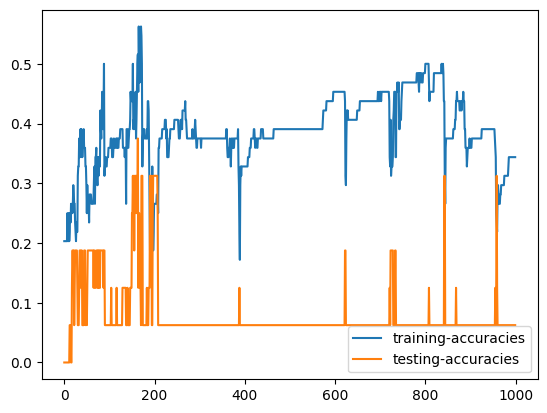

In [40]:
plt.plot(model_history.history['categorical_accuracy'] , label = 'training-accuracies')
plt.plot(model_history.history['val_categorical_accuracy'] , label ='testing-accuracies')
plt.legend(loc = 'lower right')

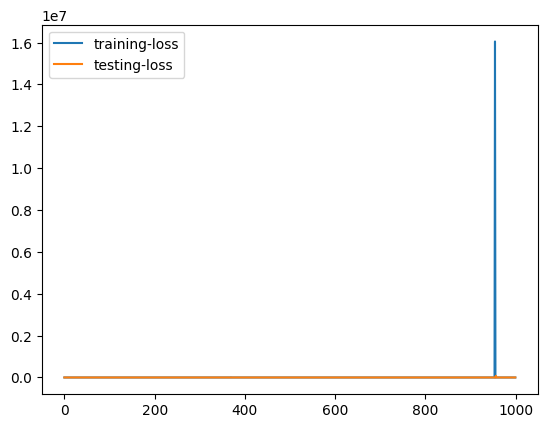

In [41]:
plt.plot(model_history.history['loss'] , label = 'training-loss')
plt.plot( model_history.history['val_loss'] , label ='testing-loss')
plt.legend(loc = 'upper left')

In [42]:
model_score = model.evaluate(X_test , Y_test , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - categorical_accuracy: 0.2000 - loss: 3.6336
